
# Group Sparse inverse covariance for multi-subject connectome

This example shows how to estimate a connectome on a group of subjects
using the group sparse inverse covariance estimate.

.. include:: ../../../examples/masker_note.rst


In [53]:
# Libraries and Paths
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import logging

# Paths and parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()


In [54]:
import numpy as np

from nilearn import plotting

n_subjects = 19  # subjects to consider for group-sparse covariance (max: 40)


def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing."""
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(
        cov,
        cmap=plotting.cm.bwr,
        vmin=-1,
        vmax=1,
        title=f"{title} / covariance",
        labels=labels,
    )
    # Display precision matrix
    plotting.plot_matrix(
        prec,
        cmap=plotting.cm.bwr,
        vmin=-span,
        vmax=span,
        title=f"{title} / precision",
        labels=labels,
    )

## Fetching datasets



In [59]:
from nilearn import datasets

# Instead of MSDL atlas, use Schaefer
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)

# Create our dataset structure
func_filenames = []
for sub in subs:  # using subs from your sub_info loading
    subject_runs = [
        f'{raw_dir}/{sub}/ses-01/derivatives/reg_standard/filtered_func_run-0{run}_standard.nii.gz'
        for run in [1, 2, 3]
    ]
    func_filenames.extend(subject_runs)
    
# print basic information on the dataset
print(f"First subject functional nifti image (4D) is at: {func_filenames[0]}")

# Print all subjects and their runs
#for i, filename in enumerate(func_filenames):
#    print(f"Subject functional nifti image {i} (4D) is at: {filename}")


First subject functional nifti image (4D) is at: /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz


In [60]:
from nilearn.maskers import NiftiMapsMasker

# masker
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(
    labels_img='/home/csimmon2/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
    standardize='zscore_sample',
    detrend=True,
    high_pass=0.01,
    t_r=2,
    verbose=2,
    memory=None
)

masker.fit()

# Your existing loop for all subjects
subject_time_series = []
for func_filename in func_filenames:
    print(f"Processing file {func_filename}")
    region_ts = masker.transform(func_filename)
    subject_time_series.append(region_ts)


[NiftiLabelsMasker.fit] loading data from /home/csimmon2/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Processing file /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-01_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Processing file /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-02_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/reg_standard/filtered_func_run-02_standard.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] 

## Computing group-sparse precision matrices



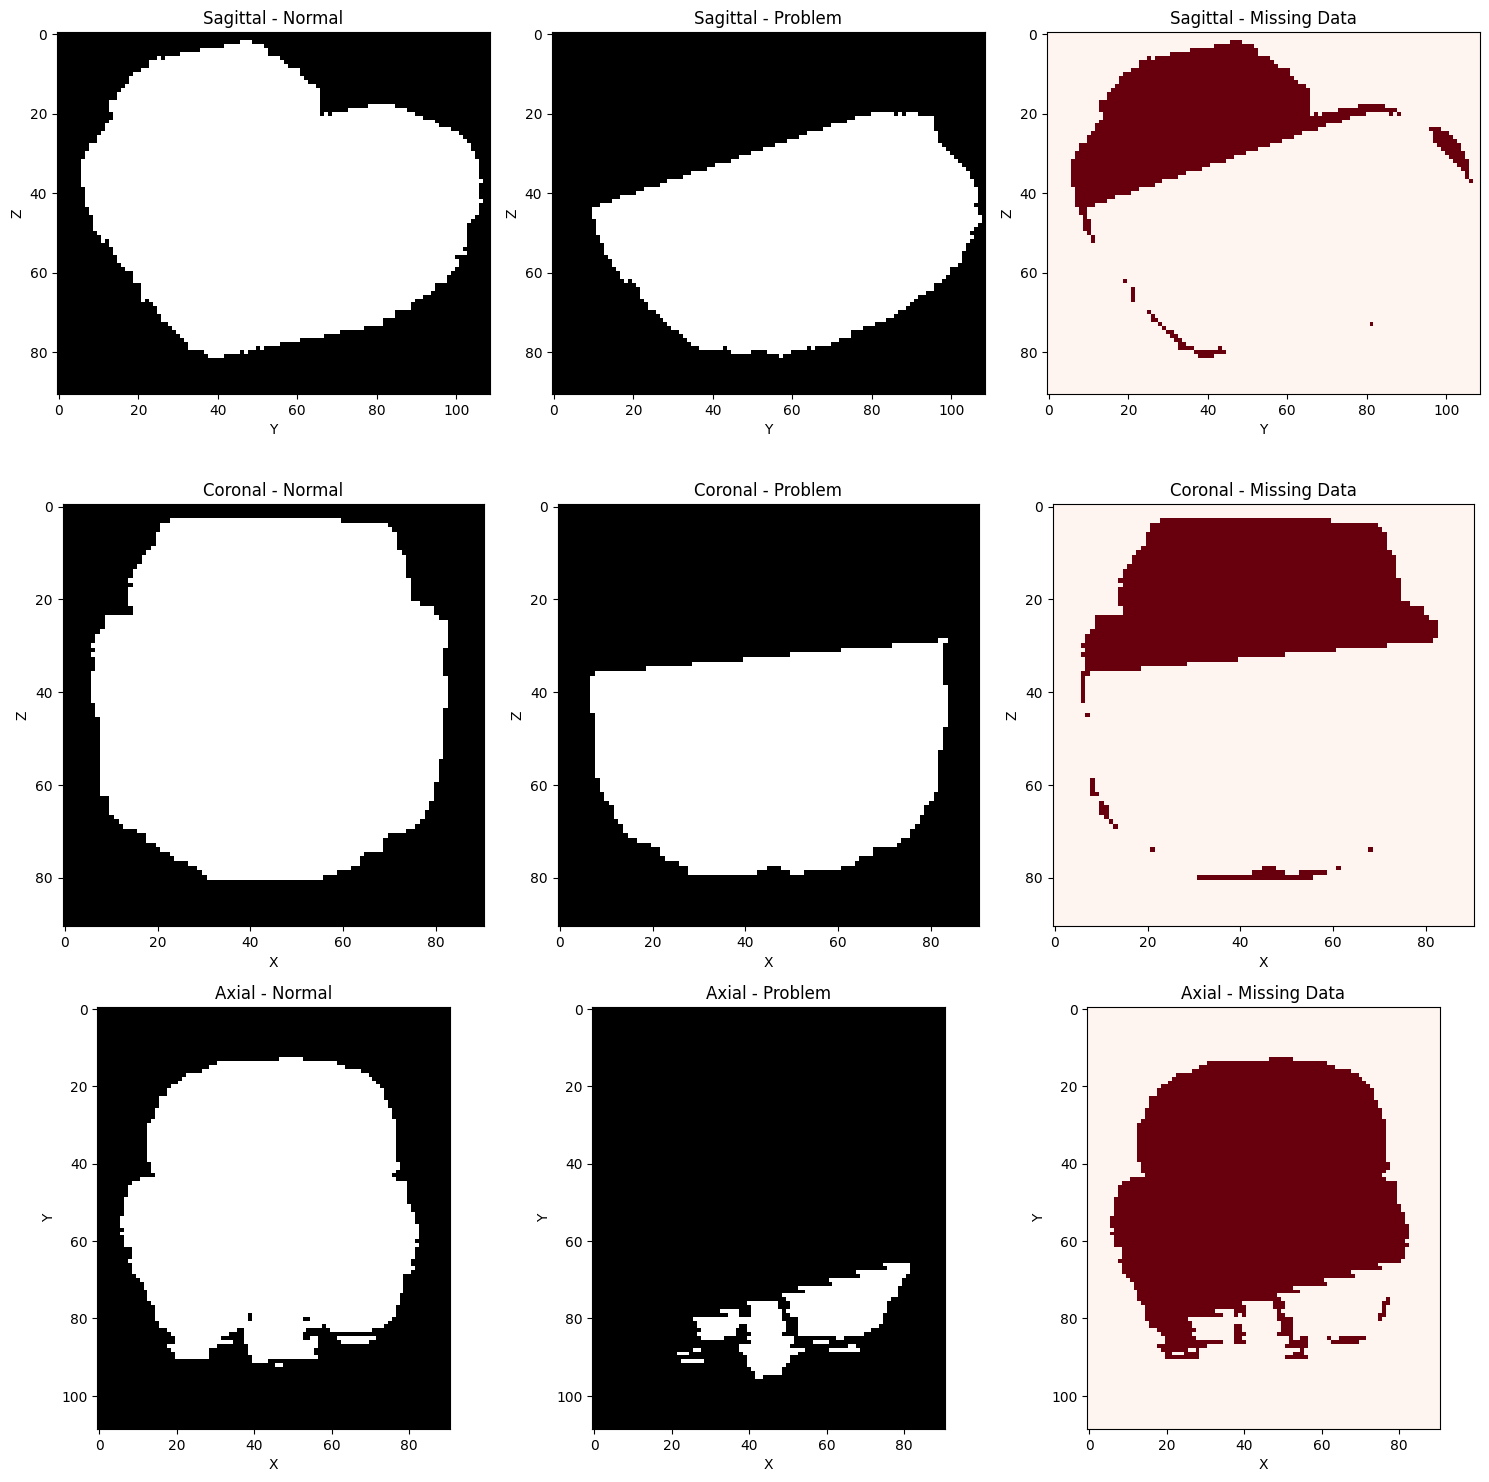

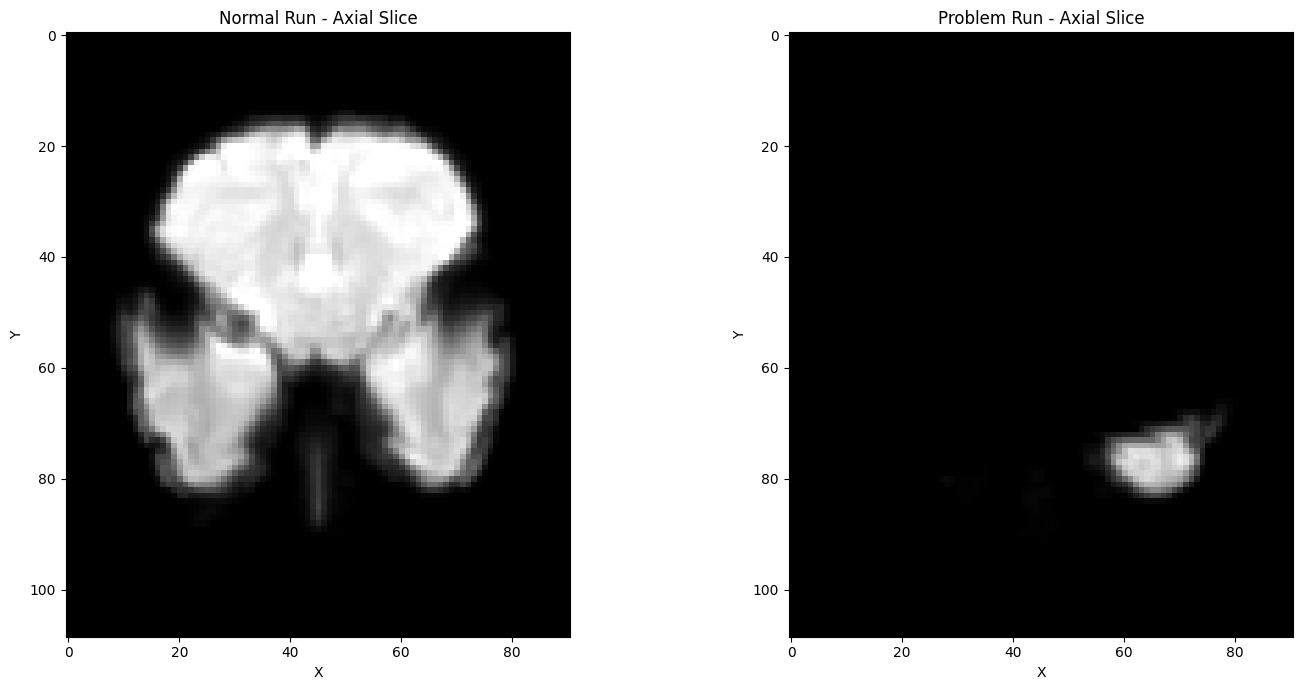

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_slices(normal_data, problem_data, slice_coords=(42, 42, 21)):
    # Create masks of non-zero voxels
    normal_mask = np.any(normal_data != 0, axis=3)
    problem_mask = np.any(problem_data != 0, axis=3)
    missing_mask = normal_mask & (~problem_mask)
    
    x, y, z = slice_coords
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Setup slice views
    views = [
        ('Sagittal', lambda d: d[x, :, :], 'Y', 'Z'),
        ('Coronal', lambda d: d[:, y, :], 'X', 'Z'),
        ('Axial', lambda d: d[:, :, z], 'X', 'Y')
    ]
    
    for row, (view_name, slicer, xlabel, ylabel) in enumerate(views):
        # Plot normal brain mask
        ax = axes[row, 0]
        im = ax.imshow(slicer(normal_mask).T, cmap='gray')
        ax.set_title(f'{view_name} - Normal')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Plot problem brain mask
        ax = axes[row, 1]
        im = ax.imshow(slicer(problem_mask).T, cmap='gray')
        ax.set_title(f'{view_name} - Problem')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Plot missing data mask
        ax = axes[row, 2]
        im = ax.imshow(slicer(missing_mask).T, cmap='Reds')
        ax.set_title(f'{view_name} - Missing Data')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_comparison_slices(normal_data, problem_data)

# Also let's look at actual signal values in a key slice
def plot_signal_comparison(normal_data, problem_data, z=21):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Get first timepoint data
    normal_slice = normal_data[:, :, z, 0]
    problem_slice = problem_data[:, :, z, 0]
    
    # Plot with a reasonable intensity range
    vmax = np.percentile(normal_slice[normal_slice != 0], 95)
    
    axes[0].imshow(normal_slice.T, cmap='gray', vmax=vmax)
    axes[0].set_title('Normal Run - Axial Slice')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    
    axes[1].imshow(problem_slice.T, cmap='gray', vmax=vmax)
    axes[1].set_title('Problem Run - Axial Slice')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    
    plt.tight_layout()
    return fig

# Create signal comparison
fig2 = plot_signal_comparison(normal_data, problem_data)

In [ ]:
from nilearn.connectome import GroupSparseCovarianceCV

gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(subject_time_series)


from sklearn.covariance import GraphicalLassoCV

gl = GraphicalLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

## Displaying results



In [ ]:
atlas_img = atlas.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = atlas.labels

plotting.plot_connectome(
    gl.covariance_,
    atlas_region_coords,
    edge_threshold="90%",
    title="Covariance",
    display_mode="lzr",
)
plotting.plot_connectome(
    -gl.precision_,
    atlas_region_coords,
    edge_threshold="90%",
    title="Sparse inverse covariance (GraphicalLasso)",
    display_mode="lzr",
    edge_vmax=0.5,
    edge_vmin=-0.5,
)
plot_matrices(gl.covariance_, gl.precision_, "GraphicalLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(
    -gsc.precisions_[..., 0],
    atlas_region_coords,
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
    edge_vmax=0.5,
    edge_vmin=-0.5,
)
plot_matrices(gsc.covariances_[..., 0], gsc.precisions_[..., 0], title, labels)

plotting.show()